In [64]:
import numpy as np
import pandas as pd
import glob
import os
import googlemaps
import geocoder
import folium
import matplotlib.pyplot as plt
import geojsoncontour

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from folium.plugins import MarkerCluster
from scipy.interpolate import griddata

In [65]:
# path = '../src/data/trip_data'
# all_files = glob.glob(os.path.join(path , "*.csv"))
# df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
df = pd.read_csv('../src/data/trip_data/sept-oct_trips.csv')
df = df.iloc[:-1]

In [66]:
df

,Device,DeviceGroup,Date,StopStart,DrivingDuration,StopEnd,Distance,StopDuration,Location,StopZoneType,IdleDuration
0,FO15921,"Vehicle, Hospital ITS","September 1, 2022","Sep 01, 2022 10:33:43 AM",0:01,"Sep 01, 2022 10:35:12 AM",0.0,0:08,"75 W 900 S, Salt Lake City, UT 84101, USA",NaN,0:00
1,FO15921,"Vehicle, Hospital ITS","September 1, 2022","Sep 01, 2022 10:43:34 AM",0:04,"Sep 01, 2022 10:47:35 AM",1.0,0:02,"175 E 800 S, Salt Lake City, UT 84111, USA",NaN,0:00
2,FO15921,"Vehicle, Hospital ITS","September 1, 2022","Sep 01, 2022 10:49:47 AM",0:05,"Sep 01, 2022 10:55:27 AM",1.0,0:05,"102 S 200 E, Salt Lake City, UT 84111, USA",NaN,0:00
3,FO15921,"Vehicle, Hospital ITS","September 1, 2022","Sep 01, 2022 11:01:15 AM",0:03,"Sep 01, 2022 11:04:17 AM",1.0,0:13,"530 E 100 S, Salt Lake City, UT 84102, USA",NaN,0:06
4,FO15921,"Vehicle, Hospital ITS","September 1, 2022","Sep 01, 2022 11:17:48 AM",0:04,"Sep 01, 2022 11:21:55 AM",0.0,0:33,"555 100 S, Salt Lake City, UT 84102, USA",NaN,0:01
...,...,...,...,...,...,...,...,...,...,...,...
38685,UOFU6483,"Vehicle, Home Infusion","October 20, 2022","Oct 20, 2022 12:47:10 PM",0:04,"Oct 20, 2022 12:51:42 PM",1.0,144:52,"6056 S Fashionsquare Dr, Murray, UT 84107, USA",NaN,0:00
38686,UOFU6483,"Vehicle, Home Infusion","October 26, 2022","Oct 26, 2022 1:44:35 PM",0:27,"Oct 26, 2022 2:12:28 PM",13.0,0:08,"5223 Duckhorn Dr, South Jordan, UT 84095, USA",NaN,0:00
38687,UOFU6483,"Vehicle, Home Infusion","October 26, 2022","Oct 26, 2022 2:20:32 PM",0:27,"Oct 26, 2022 2:47:56 PM",13.0,47:20,"6056 S Fashionsquare Dr, Murray, UT 84107, USA",NaN,0:00
38688,UOFU6483,"Vehicle, Home Infusion","October 28, 2022","Oct 28, 2022 2:08:03 PM",0:00,"Oct 28, 2022 2:08:38 PM",0.0,0:05,"6056 S Fashionsquare Dr, Murray, UT 84107, USA",NaN,0:00


In [67]:
def convert_to_minutes(d):
    if len(d) == 4:
        return int(d[:1])*60 + int(d[2:])
    elif len(d) == 5:
        return int(d[:2])*60 + int(d[3:])
    elif len(d) == 6:
        return int(d[:3])*60 + int(d[4:])

In [68]:
df['DrivingDuration'] = df['DrivingDuration'].apply(convert_to_minutes)
df['StopDuration'] = df['StopDuration'].apply(convert_to_minutes)
df['IdleDuration'] = df['IdleDuration'].apply(convert_to_minutes)
df['TripNum'] = 0
df['NonTripStop'] = False


In [69]:
trip_num = 0
for idx, row in df.iterrows():
    if row['StopDuration'] > 720:
        df['NonTripStop'].iloc[idx] = True
        trip_num += 1
    else:
        df['TripNum'].iloc[idx] = trip_num

C:\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [70]:
df = df[df['NonTripStop'] == False]

In [71]:
df['lat'] = np.nan
df['long'] = np.nan

C:\Users\Gabrielius Kudirka\AppData\Local\Temp/ipykernel_16516/4074968220.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lat'] = np.nan
C:\Users\Gabrielius Kudirka\AppData\Local\Temp/ipykernel_16516/4074968220.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['long'] = np.nan


In [72]:
df.head()

,Device,DeviceGroup,Date,StopStart,DrivingDuration,StopEnd,Distance,StopDuration,Location,StopZoneType,IdleDuration,TripNum,NonTripStop,lat,long
0,FO15921,"Vehicle, Hospital ITS","September 1, 2022","Sep 01, 2022 10:33:43 AM",1,"Sep 01, 2022 10:35:12 AM",0.0,8.0,"75 W 900 S, Salt Lake City, UT 84101, USA",NaN,0,0,False,NaN,NaN
1,FO15921,"Vehicle, Hospital ITS","September 1, 2022","Sep 01, 2022 10:43:34 AM",4,"Sep 01, 2022 10:47:35 AM",1.0,2.0,"175 E 800 S, Salt Lake City, UT 84111, USA",NaN,0,0,False,NaN,NaN
2,FO15921,"Vehicle, Hospital ITS","September 1, 2022","Sep 01, 2022 10:49:47 AM",5,"Sep 01, 2022 10:55:27 AM",1.0,5.0,"102 S 200 E, Salt Lake City, UT 84111, USA",NaN,0,0,False,NaN,NaN
3,FO15921,"Vehicle, Hospital ITS","September 1, 2022","Sep 01, 2022 11:01:15 AM",3,"Sep 01, 2022 11:04:17 AM",1.0,13.0,"530 E 100 S, Salt Lake City, UT 84102, USA",NaN,6,0,False,NaN,NaN
4,FO15921,"Vehicle, Hospital ITS","September 1, 2022","Sep 01, 2022 11:17:48 AM",4,"Sep 01, 2022 11:21:55 AM",0.0,33.0,"555 100 S, Salt Lake City, UT 84102, USA",NaN,1,0,False,NaN,NaN


In [56]:
g = geocoder.uscensus([df.Location.iloc[0]], method='batch')


In [60]:
g[0].lng

-111.89335806099996

In [37]:
g2 = geocoder.arcgis('175 E 800 S, Salt Lake City, UT 84111, USA')

In [39]:
g2.lat

40.75252397952252

In [45]:
locations = []
coords = []
for index, row in df.iterrows():
    locations.append(row.Location)
    if len(locations) == 9000:
        batch_coords = geocoder.uscensus(locations, method='batch')
        coords.extend(batch_coords)
        locations = []
batch_coords = geocoder.uscensus(locations, method='batch')
coords.extend(batch_coords)

In [63]:
coords[2].lat

40.76618892300007

In [49]:
for i, coord in enumerate(coords):
    df.lat.iloc[i] = coord.lat
    df.long.iloc[i] = coord.lng

In [55]:
coords[2].lng

-111.88536962899997

In [74]:
df

,Device,DeviceGroup,Date,StopStart,DrivingDuration,StopEnd,Distance,StopDuration,Location,StopZoneType,IdleDuration,TripNum,NonTripStop,lat,long
0,FO15921,"Vehicle, Hospital ITS","September 1, 2022","Sep 01, 2022 10:33:43 AM",1,"Sep 01, 2022 10:35:12 AM",0.0,8.0,"75 W 900 S, Salt Lake City, UT 84101, USA",NaN,0,0,False,40.749723,-111.893200
1,FO15921,"Vehicle, Hospital ITS","September 1, 2022","Sep 01, 2022 10:43:34 AM",4,"Sep 01, 2022 10:47:35 AM",1.0,2.0,"175 E 800 S, Salt Lake City, UT 84111, USA",NaN,0,0,False,40.752524,-111.885770
2,FO15921,"Vehicle, Hospital ITS","September 1, 2022","Sep 01, 2022 10:49:47 AM",5,"Sep 01, 2022 10:55:27 AM",1.0,5.0,"102 S 200 E, Salt Lake City, UT 84111, USA",NaN,0,0,False,40.766793,-111.885979
3,FO15921,"Vehicle, Hospital ITS","September 1, 2022","Sep 01, 2022 11:01:15 AM",3,"Sep 01, 2022 11:04:17 AM",1.0,13.0,"530 E 100 S, Salt Lake City, UT 84102, USA",NaN,6,0,False,40.766809,-111.875623
4,FO15921,"Vehicle, Hospital ITS","September 1, 2022","Sep 01, 2022 11:17:48 AM",4,"Sep 01, 2022 11:21:55 AM",0.0,33.0,"555 100 S, Salt Lake City, UT 84102, USA",NaN,1,0,False,40.767653,-111.874850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38681,UOFU6483,"Vehicle, Home Infusion","October 14, 2022","Oct 14, 2022 10:04:22 AM",20,"Oct 14, 2022 10:24:43 AM",14.0,7.0,"Campus: 635 Arapeen Dr, Salt Lake City, UT 841...",Campus,0,4082,False,40.615777,-111.889714
38683,UOFU6483,"Vehicle, Home Infusion","October 20, 2022","Oct 20, 2022 12:00:40 PM",20,"Oct 20, 2022 12:21:12 PM",9.0,7.0,"1260 E Stringham Avenue South Suite 100, Salt ...",NaN,0,4083,False,40.273403,-111.697365
38684,UOFU6483,"Vehicle, Home Infusion","October 20, 2022","Oct 20, 2022 12:28:44 PM",15,"Oct 20, 2022 12:43:45 PM",12.0,3.0,"897 E 6600 S, Murray, UT 84107, USA",NaN,0,4083,False,40.541889,-112.013329
38686,UOFU6483,"Vehicle, Home Infusion","October 26, 2022","Oct 26, 2022 1:44:35 PM",27,"Oct 26, 2022 2:12:28 PM",13.0,8.0,"5223 Duckhorn Dr, South Jordan, UT 84095, USA",NaN,0,4084,False,40.540574,-112.015523


In [73]:
for index, row in df.iterrows():
    location = row.Location
    g = geocoder.arcgis(location)
    if g.json is not None:
        df.lat.iloc[index] = g.json['lat']
        df.long.iloc[index] = g.json['lng']

C:\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
Status code Unknown from https://geocode.arcgis.com/arcgis/rest/services/World/GeocodeServer/find: ERROR - ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
Status code Unknown from https://geocode.arcgis.com/arcgis/rest/services/World/GeocodeServer/find: ERROR - ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


IndexError: iloc cannot enlarge its target object

In [75]:
df.to_csv('../src/data/trip_data/sept-oct_trip_latlng.csv', encoding='utf-8')

In [77]:
df['long'].isna().sum()

3737

In [ ]:
SLC_COORDINATES = [40.7608, -111.891]

slc = folium.Map(location=SLC_COORDINATES, zoom_start=12)
marker_cluster = MarkerCluster().add_to(slc)

for index, row in df.iterrows():
    location = [row["lat"],row["long"]]
    folium.Marker(location).add_to(marker_cluster)

    # slc.Marker(
    #     location = [row["lat"],row["long"]],
    #     clustered_marker = True)

slc.save('stops.html')

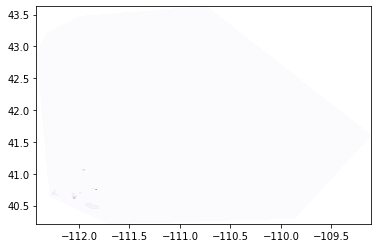

In [192]:
df_c = df[df.lat > 40]

y = df_c['lat']
x = df_c['long']
z = df_c['IdleDuration']

xi = np.linspace(x.min(),x.max(),500);
yi = np.linspace(y.min(),y.max(),500);
zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')

#alphas[:, 30:] = np.linspace(1, 0, 70)
countour = plt.contourf(xi,yi,zi,cmap='Reds', alpha=0.3)

In [ ]:
geojson = geojsoncontour.contourf_to_geojson(
    contourf=countour,
    ndigits=3,
   )

In [ ]:
with open('countour_geojson.txt', 'w') as f:
    f.write(geojson)

In [ ]:
# Convert text file to JSON 
import json 
with open('countour_geojson.txt') as json_file:     # name of the text file
    data = json.load(json_file)

# Convert JSON to GeoJson 
from geojson import dump
with open('countour_geojson.geojson', 'w') as f:   # name of the output geojson file
   dump(data, f)